<a href="https://colab.research.google.com/github/gajesh2/IHD-USING-ML-SHAP/blob/main/Finalproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from IPython.display import display # Useful for displaying DataFrames neatly in Colab

# --- Configuration ---
DATA_FILE_PATH = "/content/ihd_dataset.csv"
TARGET_COLUMN = "IHD" # Define your target variable column name

# --- Load Data ---
print("Loading data...")
try:
    df = pd.read_csv(DATA_FILE_PATH)
    print(f"Successfully loaded data from {DATA_FILE_PATH}")
except FileNotFoundError:
    print(f"Error: {DATA_FILE_PATH} not found.")
    print("Please upload the ihd_dataset.csv file to your Colab environment's /content/ directory.")
    # Stop execution or handle the error appropriately if the file is essential
    # raise # Uncomment to stop execution if file is not found

# Display the first few rows and initial columns
if 'df' in locals(): # Check if df was created
    print("\nInitial DataFrame head:")
    display(df.head())
    print("\nInitial DataFrame columns:", df.columns.tolist())

Loading data...
Successfully loaded data from /content/ihd_dataset.csv

Initial DataFrame head:


,Age,Gender,Blood_Pressure_Systolic,Cholesterol,BMI,Smoking_Status,Physical_Activity,Diabetes,Hypertension,IHD
0,68,Female,176,242,30.293827,Current,Active,0,0,1
1,58,Male,171,270,32.723577,Current,Sedentary,1,0,0
2,44,Female,178,162,29.408497,Never,Sedentary,0,0,0
3,72,Male,154,194,19.003650,Current,Moderate,1,1,1
4,37,Female,153,166,32.655673,Current,Moderate,0,0,0



Initial DataFrame columns: ['Age', 'Gender', 'Blood_Pressure_Systolic', 'Cholesterol', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Diabetes', 'Hypertension', 'IHD']


In [2]:
# %%
# --- Clean Column Names ---
print("\nCleaning column names...")
if 'df' in locals():
    df.columns = [
        c.strip()
         .replace(" ", "_")
         .replace("(", "")
         .replace(")", "")
         .replace("-", "_")
         .replace("/", "_")
         .replace(".", "_")
        for c in df.columns
    ]
    print("Column names cleaned.")
    print("Cleaned DataFrame columns:", df.columns.tolist())
else:
    print("DataFrame not found. Skipping column cleaning.")


Cleaning column names...
Column names cleaned.
Cleaned DataFrame columns: ['Age', 'Gender', 'Blood_Pressure_Systolic', 'Cholesterol', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Diabetes', 'Hypertension', 'IHD']


In [3]:
# %%
# --- Identify Categorical Columns ---
print("\nIdentifying categorical columns...")
if 'df' in locals():
    categorical_cols = df.select_dtypes(include=['object']).columns
    print("Categorical columns identified:", categorical_cols.tolist())
else:
    print("DataFrame not found. Skipping categorical column identification.")


Identifying categorical columns...
Categorical columns identified: ['Gender', 'Smoking_Status', 'Physical_Activity']


In [4]:
# %%
# --- Install Snowflake Connector ---
print("\nInstalling snowflake-connector-python...")
!pip install snowflake-connector-python==3.6.0 # Specify a version for reproducibility
print("Installation complete.")

# %%



Installing snowflake-connector-python...
Installation complete.


In [5]:
# --- Configure Snowflake Connection Details ---
# Replace these placeholders with your actual Snowflake credentials and details.
# Consider using environment variables or a secure method for credentials.
SNOWFLAKE_USER = 'Gajesh'
SNOWFLAKE_PASSWORD = 'Gajeshwaran@2580'
SNOWFLAKE_ACCOUNT = 'ylvndnf-ub40781'
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH'
SNOWFLAKE_DATABASE = 'HEART_DB'
SNOWFLAKE_SCHEMA = 'HEART_DB.IHD_SCHEMA'
SNOWFLAKE_UPLOAD_TABLE = 'IHD_PREDICTIONS_SHAP' # Your target table name for the original data

print("\nSnowflake connection details configured (using placeholders).")


Snowflake connection details configured (using placeholders).


In [6]:
# %%
import pandas as pd
from IPython.display import display
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas

# --- Configuration ---
DATA_FILE_PATH = "/content/ihd_dataset.csv"
TARGET_COLUMN = "IHD"  # Target column name

# Snowflake connection parameters
SNOWFLAKE_USER = 'Gajesh'
SNOWFLAKE_PASSWORD = 'Gajeshwaran@2580'
SNOWFLAKE_ACCOUNT = 'ylvndnf-ub40781'
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH'
SNOWFLAKE_DATABASE = 'HEART_DB'
SNOWFLAKE_SCHEMA = 'IHD_SCHEMA'
SNOWFLAKE_UPLOAD_TABLE = 'IHD_RAW_DATA'

# --- Load Data ---
print("Loading data...")
try:
    df = pd.read_csv(DATA_FILE_PATH)
    print(f"Successfully loaded data from {DATA_FILE_PATH}")
except FileNotFoundError:
    print(f"Error: {DATA_FILE_PATH} not found.")
    print("Please upload the ihd_dataset.csv file to your Colab environment's /content/ directory.")
    df = None

# Display first few rows and column names
if df is not None:
    print("\nInitial DataFrame preview:")
    display(df.head())
    print("\nDataFrame columns:", df.columns.tolist())

# --- Connect to Snowflake and Upload Data ---
if df is not None:
    print("\nAttempting to connect to Snowflake and upload data...")

    conn = None
    cursor = None

    try:
        # Establish connection
        print(" Establishing connection to Snowflake...")
        conn = snowflake.connector.connect(
            user=SNOWFLAKE_USER,
            password=SNOWFLAKE_PASSWORD,
            account=SNOWFLAKE_ACCOUNT,
            warehouse=SNOWFLAKE_WAREHOUSE,
            database=SNOWFLAKE_DATABASE,
            schema=SNOWFLAKE_SCHEMA,
        )
        print("Snowflake connection established.")

        cursor = conn.cursor()
        cursor.execute(f"USE DATABASE {SNOWFLAKE_DATABASE};")
        cursor.execute(f"USE SCHEMA {SNOWFLAKE_SCHEMA};")
        print(f"Using database `{SNOWFLAKE_DATABASE}` and schema `{SNOWFLAKE_SCHEMA}`")

        print(f"\n Uploading DataFrame to table `{SNOWFLAKE_UPLOAD_TABLE}`...")
        print("Columns in DataFrame:", df.columns.tolist())

        # Upload the DataFrame using write_pandas with auto_create_table enabled
        success, nchunks, nrows, _ = write_pandas(
            conn,
            df,
            table_name=SNOWFLAKE_UPLOAD_TABLE,
            database=SNOWFLAKE_DATABASE,
            schema=SNOWFLAKE_SCHEMA,
            quote_identifiers=False,
            auto_create_table=True  # This creates the table if it doesn't exist
        )

        print(f"Upload result: success={success}, chunks={nchunks}, rows={nrows}")

    except Exception as e:
        print(f"Error during Snowflake operation: {e}")

    finally:
        if cursor is not None:
            print("Closing cursor.")
            cursor.close()
        if conn is not None:
            print("Closing connection.")
            conn.close()
        print("Cleanup complete.")
else:
    print("DataFrame 'df' not found. Skipping upload to Snowflake.")


Loading data...
Successfully loaded data from /content/ihd_dataset.csv

Initial DataFrame preview:


,Age,Gender,Blood_Pressure_Systolic,Cholesterol,BMI,Smoking_Status,Physical_Activity,Diabetes,Hypertension,IHD
0,68,Female,176,242,30.293827,Current,Active,0,0,1
1,58,Male,171,270,32.723577,Current,Sedentary,1,0,0
2,44,Female,178,162,29.408497,Never,Sedentary,0,0,0
3,72,Male,154,194,19.003650,Current,Moderate,1,1,1
4,37,Female,153,166,32.655673,Current,Moderate,0,0,0



DataFrame columns: ['Age', 'Gender', 'Blood_Pressure_Systolic', 'Cholesterol', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Diabetes', 'Hypertension', 'IHD']

Attempting to connect to Snowflake and upload data...
 Establishing connection to Snowflake...
Snowflake connection established.
Using database `HEART_DB` and schema `IHD_SCHEMA`

 Uploading DataFrame to table `IHD_RAW_DATA`...
Columns in DataFrame: ['Age', 'Gender', 'Blood_Pressure_Systolic', 'Cholesterol', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Diabetes', 'Hypertension', 'IHD']


ERROR:snowflake.connector.ocsp_snowflake:WARNING!!! Using fail-open to connect. Driver is connecting to an HTTPS endpoint without OCSP based Certificate Revocation checking as it could not obtain a valid OCSP Response to use from the CA OCSP responder. Details: 
 {'driver': 'PythonConnector', 'version': '3.6.0', 'eventType': 'RevocationCheckFailure', 'eventSubType': 'OCSPResponseAttachedCertInvalid', 'sfcPeerHost': 'vvfgspsfcb1stg.blob.core.windows.net', 'certId': 'MEowBwYFKw4DAhoEFOR1AZ3DI+ImdB1sQDkHlfkFlkYuBBQ7cNFT6XYlnWCoymYPxpuub1QWagITMwGU9aUzVt/b+Ybg7gAAAZT1pQ==', 'ocspRequestBase64': <asn1crypto.ocsp.OCSPRequest 136637823101520 b'0R0P0N0L0J0\x07\x06\x05+\x0e\x03\x02\x1a\x04\x14\xe4u\x01\x9d\xc3#\xe2&t\x1dl@9\x07\x95\xf9\x05\x96F.\x04\x14;p\xd1S\xe9v%\x9d`\xa8\xcaf\x0f\xc6\x9b\xaeoT\x16j\x02\x133\x01\x94\xf5\xa53V\xdf\xdb\xf9\x86\xe0\xee\x00\x00\x01\x94\xf5\xa5'>, 'ocspResponderURL': 'http://oneocsp.microsoft.com/ocsp', 'errorMessage': '254009: Failed to verify the signature', 'i

Upload result: success=True, chunks=1, rows=10000
Closing cursor.
Closing connection.
Cleanup complete.


In [7]:
# %%
# --- Perform One-Hot Encoding (AFTER Snowflake Upload) ---
print("\nPerforming one-hot encoding...")
if 'df' in locals() and 'categorical_cols' in locals():
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print("One-hot encoding complete.")
    print("DataFrame AFTER one-hot encoding columns:", df.columns.tolist())
    # Display the first few rows of the encoded DataFrame
    print("\nEncoded DataFrame head:")
    display(df.head())
else:
     print("DataFrame or categorical_cols not found. Skipping one-hot encoding.")


Performing one-hot encoding...
One-hot encoding complete.
DataFrame AFTER one-hot encoding columns: ['Age', 'Blood_Pressure_Systolic', 'Cholesterol', 'BMI', 'Diabetes', 'Hypertension', 'IHD', 'Gender_Male', 'Smoking_Status_Former', 'Smoking_Status_Never', 'Physical_Activity_Moderate', 'Physical_Activity_Sedentary']

Encoded DataFrame head:


,Age,Blood_Pressure_Systolic,Cholesterol,BMI,Diabetes,Hypertension,IHD,Gender_Male,Smoking_Status_Former,Smoking_Status_Never,Physical_Activity_Moderate,Physical_Activity_Sedentary
0,68,176,242,30.293827,0,0,1,False,False,False,False,False
1,58,171,270,32.723577,1,0,0,True,False,False,False,True
2,44,178,162,29.408497,0,0,0,False,False,True,False,True
3,72,154,194,19.003650,1,1,1,True,False,False,True,False
4,37,153,166,32.655673,0,0,0,False,False,False,True,False


In [8]:
# %%
# --- Prepare Data for Modeling ---
print("\nPreparing data for modeling...")
if 'df' in locals() and TARGET_COLUMN in df.columns:
    # Define features (X) and target (y) using the one-hot encoded df
    X = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]

    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Data split into training and testing sets.")
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
else:
    print("DataFrame or target column not found. Skipping data preparation for modeling.")


Preparing data for modeling...
Data split into training and testing sets.
Shape of X_train: (8000, 11)
Shape of X_test: (2000, 11)
Shape of y_train: (8000,)
Shape of y_test: (2000,)


In [9]:
# %%
# --- Train Model ---
print("\nTraining XGBoost model...")
if 'X_train' in locals() and 'y_train' in locals():
    from xgboost import XGBClassifier
    model = XGBClassifier()
    model.fit(X_train, y_train)
    print("Model training complete.")
else:
    print("Training data not found. Skipping model training.")


Training XGBoost model...
Model training complete.



Performing SHAP analysis...
SHAP analysis complete.
Attempting to generate SHAP summary plot...


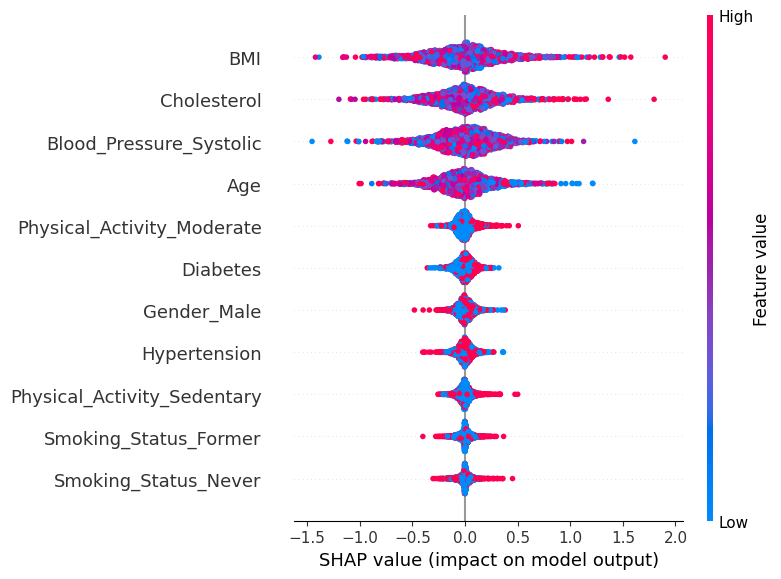

SHAP summary plot generated.


In [10]:
# %%
# --- SHAP Analysis ---
print("\nPerforming SHAP analysis...")
if 'model' in locals() and 'X_test' in locals():
    import shap
    import numpy as np

    # Use TreeExplainer for XGBoost (faster)
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    # Ensure X_test has column names that match the model's expectations (it should, as it's from the encoded df)
    try:
        shap_values = explainer.shap_values(X_test)
        print("SHAP analysis complete.")

        # Optional: Visualize locally
        # This might require adjusting Colab settings for interactive plots
        try:
            print("Attempting to generate SHAP summary plot...")
            # Handle shap_values structure for binary classification if necessary
            if isinstance(shap_values, list):
                 # Assuming SHAP values for the positive class (index 1)
                 shap.summary_plot(shap_values[1], X_test)
            else:
                 shap.summary_plot(shap_values, X_test)

            print("SHAP summary plot generated.")
        except Exception as e:
            print(f"Could not display SHAP summary plot: {e}")
            print("Consider running this code in a local environment or saving the plot to a file.")

    except Exception as e:
        print(f"Error during SHAP value calculation: {e}")
else:
    print("Model or test data not found. Skipping SHAP analysis.")

In [11]:
# %%
# --- Combine Results and SHAP Values ---
print("\nCombining results and SHAP values...")
if 'model' in locals() and 'X_test' in locals() and 'y_test' in locals() and 'shap_values' in locals():
    # Get predictions
    predictions = model.predict(X_test)

    # Convert SHAP values to DataFrame
    # Ensure column names match X_test columns
    if isinstance(shap_values, list):
        # Assuming positive class SHAP values for binary classification
        shap_df = pd.DataFrame(shap_values[1], columns=X_test.columns)
    else:
         shap_df = pd.DataFrame(shap_values, columns=X_test.columns)


    # Combine all results (X_test, predictions, true labels, SHAP values)
    # Ensure indexes are aligned before concatenation
    results_df = X_test.copy().reset_index(drop=True)
    results_df['Prediction'] = predictions
    results_df['True_Label'] = y_test.reset_index(drop=True) # Ensure y_test index is reset

    # Concatenate with SHAP values, adding a prefix
    results_df = pd.concat([results_df, shap_df.add_prefix("SHAP_")], axis=1)

    # Clean columns again for the final result DataFrame
    results_df.columns = [
        str(c).strip()
            .replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
            .replace("-", "_")
            .replace("/", "_")
            .replace(".", "_")
        for c in results_df.columns
    ]

    print("Results and SHAP values combined.")
    print("\nFinal results DataFrame head:")
    display(results_df.head())
    print("\nFinal results DataFrame columns:", results_df.columns.tolist())
else:
    print("Required data for combining results not found. Skipping this step.")


Combining results and SHAP values...
Results and SHAP values combined.

Final results DataFrame head:


,Age,Blood_Pressure_Systolic,Cholesterol,BMI,Diabetes,Hypertension,Gender_Male,Smoking_Status_Former,Smoking_Status_Never,Physical_Activity_Moderate,...,SHAP_Blood_Pressure_Systolic,SHAP_Cholesterol,SHAP_BMI,SHAP_Diabetes,SHAP_Hypertension,SHAP_Gender_Male,SHAP_Smoking_Status_Former,SHAP_Smoking_Status_Never,SHAP_Physical_Activity_Moderate,SHAP_Physical_Activity_Sedentary
0,60,158,201,31.699896,0,1,True,True,False,True,...,-0.546609,0.040004,-0.442066,-0.118014,0.007574,0.107341,-0.035916,0.016251,-0.074374,0.017444
1,35,108,224,26.703850,0,1,True,False,True,False,...,0.064833,-0.082898,0.037817,0.006024,0.007579,0.029747,0.010257,-0.042543,-0.047678,0.012352
2,66,121,159,20.048177,1,1,True,False,False,False,...,0.430117,0.215297,0.081434,-0.044462,-0.045357,-0.209924,-0.011598,0.050410,-0.030770,-0.035937
3,64,151,213,27.865727,0,1,False,False,False,False,...,-0.194449,0.087037,-0.313151,-0.070986,-0.018801,0.034476,0.023577,-0.008807,0.022999,-0.022811
4,60,177,212,24.397323,1,1,False,False,True,False,...,0.117161,-0.168966,0.218851,0.089273,0.027336,-0.026037,0.078126,-0.014866,0.079763,0.024087



Final results DataFrame columns: ['Age', 'Blood_Pressure_Systolic', 'Cholesterol', 'BMI', 'Diabetes', 'Hypertension', 'Gender_Male', 'Smoking_Status_Former', 'Smoking_Status_Never', 'Physical_Activity_Moderate', 'Physical_Activity_Sedentary', 'Prediction', 'True_Label', 'SHAP_Age', 'SHAP_Blood_Pressure_Systolic', 'SHAP_Cholesterol', 'SHAP_BMI', 'SHAP_Diabetes', 'SHAP_Hypertension', 'SHAP_Gender_Male', 'SHAP_Smoking_Status_Former', 'SHAP_Smoking_Status_Never', 'SHAP_Physical_Activity_Moderate', 'SHAP_Physical_Activity_Sedentary']
